# Week 9 - homework: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1004657"
student_name="Samuel Sim Wei Xuan"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Samuel Sim Wei Xuan, number: 1004657


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). In other words: if I input bee, generate me an image of a bee. If I input ant, generate an image of an ant. 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

In [2]:
!pip install wget
import os
import wget
import zipfile
import shutil

# Downloading, unzipping and combining the train, validation files
wget.download("https://download.pytorch.org/tutorial/hymenoptera_data.zip")
with zipfile.ZipFile("hymenoptera_data.zip", 'r') as zip_ref:
    zip_ref.extractall()

os.makedirs('hymenoptera_data/combined/ants', exist_ok=True)
os.makedirs('hymenoptera_data/combined/bees', exist_ok=True)

for filename in os.listdir("hymenoptera_data/train/ants"):
    os.rename("hymenoptera_data/train/ants/" + filename, "hymenoptera_data/combined/ants/" + filename)
for filename in os.listdir("hymenoptera_data/val/ants"):
    os.rename("hymenoptera_data/val/ants/" + filename, "hymenoptera_data/combined/ants/" + filename)

for filename in os.listdir("hymenoptera_data/train/bees"):
    os.rename("hymenoptera_data/train/bees/" + filename, "hymenoptera_data/combined/bees/" + filename)
for filename in os.listdir("hymenoptera_data/val/bees"):
    os.rename("hymenoptera_data/val/bees/" + filename, "hymenoptera_data/combined/bees/" + filename)

os.remove("hymenoptera_data.zip")
shutil.rmtree('hymenoptera_data/train', ignore_errors=True)
shutil.rmtree('hymenoptera_data/val', ignore_errors=True)

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb and the previously mentioned link. 


In [3]:
from torchvision import datasets, models, transforms
import torch.utils.data as data
import torch

# Normalize and data augmentation (using pretrained model, need ensure same as the model used for training)
data_transforms = {
    'combined': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

data_directory = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_directory, x), data_transforms[x]) for x in ['combined']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in ['combined']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\samue\anaconda3\envs\data_science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



c) Show a few images from the dataset so we understand what we are working with. 



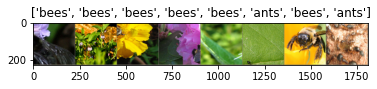

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Get a batch of the training data from the data loader and make a grid
inputs, classes = next(iter(dataloaders['combined']))
outputs = make_grid(inputs)

# Get the class labels for the training data
class_names = image_datasets['combined'].classes

# Plot the images in the batch, along with the corresponding class labels
def imshow_tensor(tensors_images, title):
    images = tensors_images.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    plt.imshow(images)
    plt.title(title)
    
imshow_tensor(outputs, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [5]:
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from PIL import Image
from torch import autograd
from torch.autograd import Variable

latent_dims = 50
batch_size = 8
capacity = 32
variational_beta = 1
img_size = inputs.shape[3] # 224

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.label_emb = nn.Embedding(2, img_size*img_size)
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 112 x 112 --> (224 - 4 + 2(1) / 2) + 1 = 111 + 1 = 112
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c*2 x 56 x 56 --> (112 - 4 + 2(1) / 2) + 1 = 55 + 1 = 56
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1) # out: c*4 x 28 x 28 --> (56 - 4 + 2(1) / 2) + 1 = 27 + 1 = 28
        self.conv4 = nn.Conv2d(in_channels=c*4, out_channels=c*8, kernel_size=4, stride=2, padding=1) # out: c*8 x 14 x 14 --> (28 - 4 + 2(1) / 2) + 1 = 13 + 1 = 14
        self.conv5 = nn.Conv2d(in_channels=c*8, out_channels=c*16, kernel_size=4, stride=2, padding=1) # out: c*16 x 7 x 7 --> (16 - 4 + 2(1) / 2) + 1 = 6 + 1 = 7
        self.fc_mu = nn.Linear(in_features=c*16*7*7, out_features=latent_dims) # out: latent_dims
        self.fc_logvar = nn.Linear(in_features=c*16*7*7, out_features=latent_dims) # out: latent_dims
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 224*224)
        c = c.view(-1, 1, 224, 224) # (batch_size, 1, 224, 224)
        x = torch.cat([x, c], axis=1) # (batch_size, 4, 224, 224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x) # use use x for mu and for variance
        x_logvar = self.fc_logvar(x) #we don't calculate this from x_mu but from x
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.label_emb = nn.Embedding(2, 1)
        c = capacity
        self.fc1 = nn.Linear(in_features=latent_dims+1, out_features=c*16*7*7)
        self.conv5 = nn.ConvTranspose2d(in_channels=c*16, out_channels=c*8, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=c*8, out_channels=c*4, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 1)
        x = torch.cat([x, c], axis=1) # (batch_size, latent_dims+1)
        x = self.fc1(x)
        x = x.view(x.size(0), capacity*16, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        return x 

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x, labels):
        # remember our encoder output consists of x_mu and x_logvar
        latent_mu, latent_logvar = self.encoder(x, labels)
        # we sample from the distributions defined by mu and logvar, function latent_sample defined below
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, labels)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() #define normal distribution
            return eps.mul(std).add_(mu) #sample from normal distribution
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.mse_loss(recon_x.view(-1, 3*224*224), x.view(-1, 3*224*224), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training. This should be done regularly during training so you can follow the process. 





VariationalAutoencoder(
  (encoder): Encoder(
    (label_emb): Embedding(2, 50176)
    (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=25088, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=25088, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (label_emb): Embedding(2, 1)
    (fc1): Linear(in_features=51, out_features=25088, bias=True)
    (conv5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

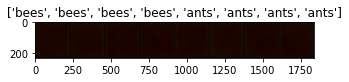

Epoch [2 / 200] average reconstruction error: 1546921.777500
Epoch [3 / 200] average reconstruction error: 1405809.732500
Epoch [4 / 200] average reconstruction error: 1322566.590000
Epoch [5 / 200] average reconstruction error: 1142538.623750
Epoch [6 / 200] average reconstruction error: 974881.427500
Epoch [7 / 200] average reconstruction error: 908030.128750
Epoch [8 / 200] average reconstruction error: 901449.675000
Epoch [9 / 200] average reconstruction error: 865553.672500
Epoch [10 / 200] average reconstruction error: 855810.556250
Epoch [11 / 200] average reconstruction error: 805676.334375


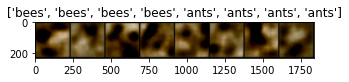

Epoch [12 / 200] average reconstruction error: 759449.061250
Epoch [13 / 200] average reconstruction error: 705050.097500
Epoch [14 / 200] average reconstruction error: 686451.603750
Epoch [15 / 200] average reconstruction error: 679043.333125
Epoch [16 / 200] average reconstruction error: 659375.259375
Epoch [17 / 200] average reconstruction error: 665727.150625
Epoch [18 / 200] average reconstruction error: 641444.123125
Epoch [19 / 200] average reconstruction error: 621754.958125
Epoch [20 / 200] average reconstruction error: 626369.013125
Epoch [21 / 200] average reconstruction error: 611386.738750


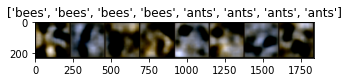

Epoch [22 / 200] average reconstruction error: 617233.865000
Epoch [23 / 200] average reconstruction error: 601220.311875
Epoch [24 / 200] average reconstruction error: 583228.761250
Epoch [25 / 200] average reconstruction error: 581213.451250
Epoch [26 / 200] average reconstruction error: 574008.091250
Epoch [27 / 200] average reconstruction error: 560141.758125
Epoch [28 / 200] average reconstruction error: 563213.883125
Epoch [29 / 200] average reconstruction error: 563609.878125
Epoch [30 / 200] average reconstruction error: 553195.788125
Epoch [31 / 200] average reconstruction error: 560039.770625


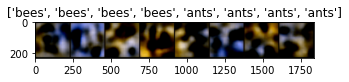

Epoch [32 / 200] average reconstruction error: 545181.402500
Epoch [33 / 200] average reconstruction error: 548002.883750
Epoch [34 / 200] average reconstruction error: 532474.647500
Epoch [35 / 200] average reconstruction error: 540333.876875
Epoch [36 / 200] average reconstruction error: 538402.689375
Epoch [37 / 200] average reconstruction error: 533247.593750
Epoch [38 / 200] average reconstruction error: 526601.600000
Epoch [39 / 200] average reconstruction error: 531655.735625
Epoch [40 / 200] average reconstruction error: 541062.897500
Epoch [41 / 200] average reconstruction error: 539719.641875


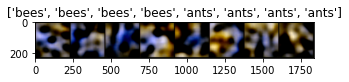

Epoch [42 / 200] average reconstruction error: 522359.688750
Epoch [43 / 200] average reconstruction error: 522035.279375
Epoch [44 / 200] average reconstruction error: 530541.670625
Epoch [45 / 200] average reconstruction error: 516682.504375
Epoch [46 / 200] average reconstruction error: 523624.419375
Epoch [47 / 200] average reconstruction error: 500377.605000
Epoch [48 / 200] average reconstruction error: 500725.914375
Epoch [49 / 200] average reconstruction error: 513131.285625
Epoch [50 / 200] average reconstruction error: 504217.935625
Epoch [51 / 200] average reconstruction error: 523655.881250


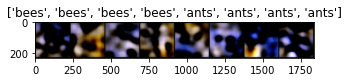

Epoch [52 / 200] average reconstruction error: 513717.075937
Epoch [53 / 200] average reconstruction error: 507714.938125
Epoch [54 / 200] average reconstruction error: 507666.172500
Epoch [55 / 200] average reconstruction error: 499019.431875
Epoch [56 / 200] average reconstruction error: 498529.895000
Epoch [57 / 200] average reconstruction error: 498187.992500
Epoch [58 / 200] average reconstruction error: 506760.588750
Epoch [59 / 200] average reconstruction error: 497617.248750
Epoch [60 / 200] average reconstruction error: 506069.841250
Epoch [61 / 200] average reconstruction error: 498458.822500


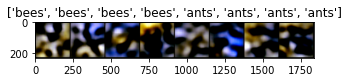

Epoch [62 / 200] average reconstruction error: 506321.862500
Epoch [63 / 200] average reconstruction error: 495817.683750
Epoch [64 / 200] average reconstruction error: 507287.768125
Epoch [65 / 200] average reconstruction error: 501714.513125
Epoch [66 / 200] average reconstruction error: 499834.633125
Epoch [67 / 200] average reconstruction error: 497214.569375
Epoch [68 / 200] average reconstruction error: 489709.385625
Epoch [69 / 200] average reconstruction error: 486085.356875
Epoch [70 / 200] average reconstruction error: 498012.482500
Epoch [71 / 200] average reconstruction error: 492872.221875


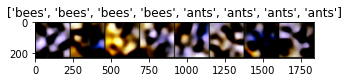

Epoch [72 / 200] average reconstruction error: 506893.875937
Epoch [73 / 200] average reconstruction error: 519335.687500
Epoch [74 / 200] average reconstruction error: 504100.145937
Epoch [75 / 200] average reconstruction error: 499462.788750
Epoch [76 / 200] average reconstruction error: 506264.055625
Epoch [77 / 200] average reconstruction error: 498112.471250
Epoch [78 / 200] average reconstruction error: 492387.204375
Epoch [79 / 200] average reconstruction error: 485950.746875
Epoch [80 / 200] average reconstruction error: 494829.454375
Epoch [81 / 200] average reconstruction error: 492952.239375


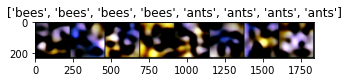

Epoch [82 / 200] average reconstruction error: 492540.601875
Epoch [83 / 200] average reconstruction error: 497347.555000
Epoch [84 / 200] average reconstruction error: 492163.830625
Epoch [85 / 200] average reconstruction error: 484205.083125
Epoch [86 / 200] average reconstruction error: 500337.197500
Epoch [87 / 200] average reconstruction error: 493213.671875
Epoch [88 / 200] average reconstruction error: 479239.568437
Epoch [89 / 200] average reconstruction error: 490793.604375
Epoch [90 / 200] average reconstruction error: 486805.394375
Epoch [91 / 200] average reconstruction error: 495137.251875


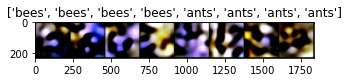

Epoch [92 / 200] average reconstruction error: 490748.338125
Epoch [93 / 200] average reconstruction error: 484507.049375
Epoch [94 / 200] average reconstruction error: 507124.818750
Epoch [95 / 200] average reconstruction error: 488761.321875
Epoch [96 / 200] average reconstruction error: 476958.172500
Epoch [97 / 200] average reconstruction error: 483711.977500
Epoch [98 / 200] average reconstruction error: 486190.268125
Epoch [99 / 200] average reconstruction error: 487644.880625
Epoch [100 / 200] average reconstruction error: 474902.599375
Epoch [101 / 200] average reconstruction error: 478476.908125


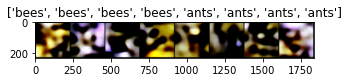

Epoch [102 / 200] average reconstruction error: 487896.017500
Epoch [103 / 200] average reconstruction error: 492334.326250
Epoch [104 / 200] average reconstruction error: 477797.181875
Epoch [105 / 200] average reconstruction error: 484845.032500
Epoch [106 / 200] average reconstruction error: 488798.475625
Epoch [107 / 200] average reconstruction error: 474426.458125
Epoch [108 / 200] average reconstruction error: 486633.370625
Epoch [109 / 200] average reconstruction error: 486325.624375
Epoch [110 / 200] average reconstruction error: 470784.687812
Epoch [111 / 200] average reconstruction error: 456536.075625


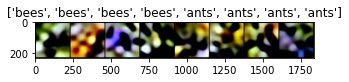

Epoch [112 / 200] average reconstruction error: 465464.455937
Epoch [113 / 200] average reconstruction error: 441030.475625
Epoch [114 / 200] average reconstruction error: 440675.976562
Epoch [115 / 200] average reconstruction error: 460998.638125
Epoch [116 / 200] average reconstruction error: 453665.326562
Epoch [117 / 200] average reconstruction error: 441706.304375
Epoch [118 / 200] average reconstruction error: 441251.231250
Epoch [119 / 200] average reconstruction error: 447352.713125
Epoch [120 / 200] average reconstruction error: 441367.504375
Epoch [121 / 200] average reconstruction error: 438511.647813


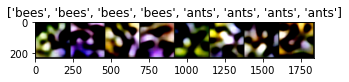

Epoch [122 / 200] average reconstruction error: 434550.265313
Epoch [123 / 200] average reconstruction error: 432698.478750
Epoch [124 / 200] average reconstruction error: 439111.278750
Epoch [125 / 200] average reconstruction error: 434546.849062
Epoch [126 / 200] average reconstruction error: 438878.768125
Epoch [127 / 200] average reconstruction error: 439917.124063
Epoch [128 / 200] average reconstruction error: 439093.059688
Epoch [129 / 200] average reconstruction error: 434655.466250
Epoch [130 / 200] average reconstruction error: 433626.193437
Epoch [131 / 200] average reconstruction error: 435218.937500


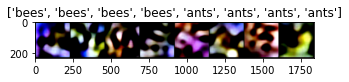

Epoch [132 / 200] average reconstruction error: 438312.091250
Epoch [133 / 200] average reconstruction error: 437738.505000
Epoch [134 / 200] average reconstruction error: 440390.948125
Epoch [135 / 200] average reconstruction error: 426989.868750
Epoch [136 / 200] average reconstruction error: 437101.747188
Epoch [137 / 200] average reconstruction error: 438125.993750
Epoch [138 / 200] average reconstruction error: 439413.418750
Epoch [139 / 200] average reconstruction error: 426753.510313
Epoch [140 / 200] average reconstruction error: 435932.983125
Epoch [141 / 200] average reconstruction error: 426870.137188


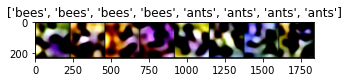

Epoch [142 / 200] average reconstruction error: 432199.119688
Epoch [143 / 200] average reconstruction error: 428092.560000
Epoch [144 / 200] average reconstruction error: 434791.852812
Epoch [145 / 200] average reconstruction error: 427007.978438
Epoch [146 / 200] average reconstruction error: 426049.393750
Epoch [147 / 200] average reconstruction error: 424458.288750
Epoch [148 / 200] average reconstruction error: 428310.031875
Epoch [149 / 200] average reconstruction error: 428940.958437
Epoch [150 / 200] average reconstruction error: 431808.385625
Epoch [151 / 200] average reconstruction error: 428778.908750


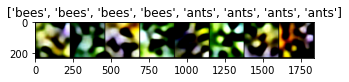

Epoch [152 / 200] average reconstruction error: 426828.486250
Epoch [153 / 200] average reconstruction error: 431369.260625
Epoch [154 / 200] average reconstruction error: 430300.250000
Epoch [155 / 200] average reconstruction error: 433668.191250
Epoch [156 / 200] average reconstruction error: 431231.488125
Epoch [157 / 200] average reconstruction error: 431004.466875
Epoch [158 / 200] average reconstruction error: 431732.062188
Epoch [159 / 200] average reconstruction error: 426478.785000
Epoch [160 / 200] average reconstruction error: 421948.088750
Epoch [161 / 200] average reconstruction error: 433053.740625


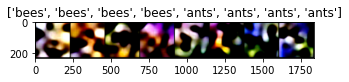

Epoch [162 / 200] average reconstruction error: 421973.288438
Epoch [163 / 200] average reconstruction error: 427189.129688
Epoch [164 / 200] average reconstruction error: 431258.829375
Epoch [165 / 200] average reconstruction error: 427471.373437
Epoch [166 / 200] average reconstruction error: 435006.378750
Epoch [167 / 200] average reconstruction error: 432026.583125
Epoch [168 / 200] average reconstruction error: 433942.398750
Epoch [169 / 200] average reconstruction error: 422780.205625
Epoch [170 / 200] average reconstruction error: 423098.368125
Epoch [171 / 200] average reconstruction error: 423203.158125


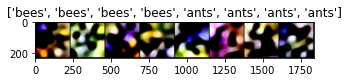

Epoch [172 / 200] average reconstruction error: 433274.911875
Epoch [173 / 200] average reconstruction error: 433194.836875
Epoch [174 / 200] average reconstruction error: 437078.449062
Epoch [175 / 200] average reconstruction error: 432046.963125
Epoch [176 / 200] average reconstruction error: 424455.835625
Epoch [177 / 200] average reconstruction error: 418966.612187
Epoch [178 / 200] average reconstruction error: 428838.412187
Epoch [179 / 200] average reconstruction error: 420417.763437
Epoch [180 / 200] average reconstruction error: 431989.796250
Epoch [181 / 200] average reconstruction error: 416632.844687


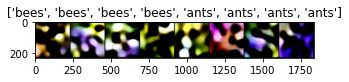

Epoch [182 / 200] average reconstruction error: 421170.551250
Epoch [183 / 200] average reconstruction error: 427405.298750
Epoch [184 / 200] average reconstruction error: 421032.145313
Epoch [185 / 200] average reconstruction error: 433767.368437
Epoch [186 / 200] average reconstruction error: 422109.569063
Epoch [187 / 200] average reconstruction error: 425776.545000
Epoch [188 / 200] average reconstruction error: 427134.184688
Epoch [189 / 200] average reconstruction error: 423106.545625
Epoch [190 / 200] average reconstruction error: 423132.671875
Epoch [191 / 200] average reconstruction error: 422674.855625


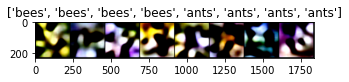

Epoch [192 / 200] average reconstruction error: 416455.153438
Epoch [193 / 200] average reconstruction error: 425556.410625
Epoch [194 / 200] average reconstruction error: 419553.134062
Epoch [195 / 200] average reconstruction error: 429681.178438
Epoch [196 / 200] average reconstruction error: 422428.627188
Epoch [197 / 200] average reconstruction error: 424574.449375
Epoch [198 / 200] average reconstruction error: 426043.441875
Epoch [199 / 200] average reconstruction error: 425385.062500
Epoch [200 / 200] average reconstruction error: 423294.130625


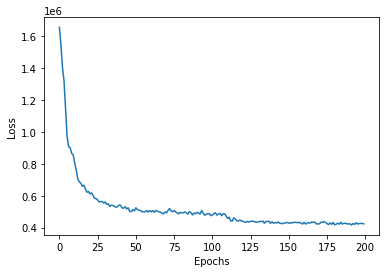

In [6]:
# train the network
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img, classes):
    img = to_img(img)
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.title(classes)
    plt.imshow(img)

num_epochs = 200
use_gpu = True
learning_rate = 1e-4
sample_size = 8

vae = VariationalAutoencoder().to(device)
print(vae)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
train_loss_avg = []

for epoch in range(num_epochs):
    # set to training mode
    vae.train()
    train_loss_avg.append(0)  
    num_batches = 0 
    for i, (image_batch, labels) in enumerate(dataloaders['combined']):        
        image_batch = image_batch.to(device)
        labels = labels.to(device)
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, labels)        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()        
        train_loss_avg[-1] += loss.item()    
        num_batches += 1    
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

    if epoch % 10 == 0:
        vae.eval()
        with torch.no_grad():
            # sample latent vectors from the normal distribution
            latent = torch.randn(sample_size, latent_dims).to(device)
            # reconstruct images from the latent vectors
            labels = torch.LongTensor([1,1,1,1,0,0,0,0]).to(device)
            classes = [class_names[i] for i in labels]
            img_recon = vae.decoder(latent, labels)
            img_recon = img_recon.cpu()
            fig, ax = plt.subplots(figsize=(5, 5))
            show_image(make_grid(img_recon.data[:8],8,5), classes)
            plt.show()
            
# loss evolve during training
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

g) Showcase how your model can now take an input option and generate the appropriate image. Show this for both ants and bees. 

In [7]:
# ASSUMPTION: Takes in a single image and generate the single image
def predict_single_image(image_path, str_label:str):
    # Prepare the image and label for the model
    image = Image.open(image_path)
    image = image.resize((224, 224), Image.ANTIALIAS)
    image = np.array(image)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image).float().unsqueeze(0)
    image = image.to(device)
    label = torch.LongTensor([class_names.index(str_label)]).to(device)

    # run image through model
    vae.eval()
    image_recon, latent_mu, latent_logvar = vae(image, label)
    image_recon = image_recon.cpu()
    
    # convert to numpy for display
    image_to_display = image_recon.data.squeeze(0)
    image_to_display = image_to_display.cpu()
    image_to_display = image_to_display.numpy()
    image_to_display = np.transpose(image_to_display, (1, 2, 0))
    
    # display image
    plt.title(str_label)
    plt.imshow(image_to_display/255)

    # return image_recon

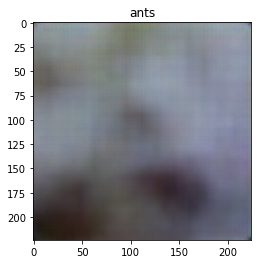

In [8]:
predict_single_image('hymenoptera_data/combined/ants/6240329_72c01e663e.jpg', 'ants')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


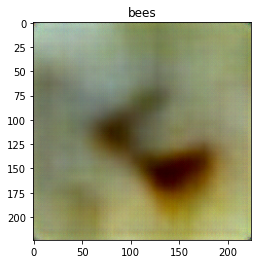

In [9]:
predict_single_image('hymenoptera_data/combined/bees/522104315_5d3cb2758e.jpg', 'bees')

h) Does this model work well enough? What might be the reason for this? Do you have any suggestions for improvement? 


In [10]:
# number of images for our training
[len(image_datasets[x]) for x in ['combined']]

[397]

From the output images, we can tell the model does not work well enough. This could be due to the small size of training data as shown above, hence our model is unable to capture the features well. An easy yet expensive improvement would be to collect more data.

i) Is the loss function enough to assess the quality of the images? If not, how could you improve the evaluation? 

No, using a loss function alone is not enough to assess the quality of the images. In fact using MSE pixel loss does not adequately capture the images qualities that we humans desire, in terms of the aesthetics and quality. Here is a very nice article illustrating so, https://medium.com/@olegrybkin_20684/the-reasonable-ineffectiveness-of-mse-pixel-loss-for-future-prediction-and-what-to-do-about-it-4dca8152355d. Instead, we can make use of other evaluation metrics such as structural similarity index measure (SSIM) or even the common Peak signal-to-noise ratio (PSNR).